## Finite Element Solution of the 1D Heat equation
### Lars Bosch, Philipp Brückelt, Thomas Engl

----------------------------------------------------------------------------------------------------

We solve the initial boundary value problem (IBVP)
$$
\left\{ \begin{array}{rll}
\partial_{tt}^2 u - \kappa \partial_{xx}^2 u &= f &\text{in } (0, 1), \\
u(t, 0) = u(t, 1) &= 0  &\text{for } t > 0,  \\
u(0, x) &= u_0 &\text{in } (0, 1)
\end{array} \right.
$$
where $\kappa > 0$, $u_0 ( x ) = \sin ( \pi x )$ and $f(x) = 0$ or $f(x) = \sin ( \pi x )$.

In [1]:
# import required modules

import importlib.util
import numpy as np
import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
import numpy as np

# for plotting / animation

import pyvista as pv
import matplotlib.pyplot as plt
from matplotlib import animation, rc, rcParams
from matplotlib.tri import Triangulation
from IPython.display import HTML
from mpi4py import MPI

# for nice output
from IPython.display import Math, display


import time

At the start, please chose which example you want to see. Either 0 or 1, where 0 means that the right hand side is given by
$$
f \equiv 0.
$$
If you chose 1, the right hand side is given by
$$
f(x) = \sin ( \pi x ).
$$

In [12]:
# set example to either 0 or 1
# initial conditions and analytic solutions are defined later
example = 0

In [13]:
### copied this block from the dolfinx tutorial

if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx

    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
    from petsc4py.PETSc import ScalarType  # type: ignore
else:
    print("This demo requires petsc4py.")
    exit(0)

In [14]:
### =======================================================================
### solve the two-dimensional heat equation in \Omega = (0, 1)
### u_t - \kappa \Delta u = f    in \Omega
###     u(0, t) = u(1, t) = 0    for t > 0
###               u(0, -) = u_0


### =======================================================================
### create an equdistant mesh on (0, 1) with 128 cells 

msh = mesh.create_unit_interval(
    comm=MPI.COMM_WORLD,
    nx=128
)

# use Lagrange elements of degree 1
V = fem.functionspace(msh, ("Lagrange", 1))

# implement homogeneous Dirichlet boundary conditions
# u = 0 on the boundary, i.e., for x \in \{0, 1\}

facets = mesh.locate_entities_boundary(
    msh,
    dim=0,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0),
)

# find degrees of freedom

dofs = fem.locate_dofs_topological(V=V, entity_dim=0, entities=facets)

# create a fem class representing the boundary conditions

bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [15]:
# Iterate over all time steps: Choose h = 0.005 as step size
# this ensures that the development of the solution in time can be
# observed well in the animation

h = 0.005

x = ufl.SpatialCoordinate(msh)

In the following code block, define the functions $u_0$ and $f$.

In [16]:
### =======================================================================
### initial condition u_0
### u_0 (x) = sin ( pi * x )
### create a ufl expression and transform it into a fem function later

u0 = ufl.sin(np.pi * x[0]) + ufl.sin(4 * np.pi * x[0])

### =======================================================================
### right hand side
### depends on which example you want to see

# define different initial conditions - easy if f = 0.
f1 = fem.Function(V)
rhs1 = ufl.sin(np.pi * x[0])
f1_ = fem.Expression(rhs1, V.element.interpolation_points())
f1.interpolate(f1_)

rhs = [fem.Constant(msh, 0.0), f1]

# take the right hand side that was chosen before
f = rhs[example]

# create a list of solutions
# to add u0, we need to transform it into a dolfin function at first
# set u_n = u_0 (interpolate u0 on the grid to obtain the correct data type)

u_n = fem.Function(V)
u0_ = fem.Expression(u0, V.element.interpolation_points())
u_n.interpolate(u0_)
lst_solutions = [u_n.copy()]

In [17]:
# diffusivity coefficient \kappa

kappa = 0.1

# number of time steps

num_steps = 200

This block computes the FEM solution. We also measure the runtime of this block.

In [28]:
start = time.perf_counter()

for i in range(num_steps):

    ### =================================================================
    ### Construct the variational problem
    ### Discretize the time by finite differences to obtain the equation
    ### u^{n+1} = h ( f^{n+1} + \kappa \Delta u^{n+1} ) + u^{n}
    ### where u^{n}, f^{n} are the respective functions at time step n
    ### in the following, u^{n} and f^{n} are simply denoted by u and f,
    ### respectively.
    ### then derive the weak formulation


    # initialize trial and test function

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)  

    ### =================================================================
    ### bilinear form and linear form
    ### a(u, v) = \int_{\Omega} uv + h \kappa \nabla u \cdot \nabla v dx
    ### l(v) = \int_{\Omega} (hf + u^{n})v dx

    # inner denotes the standard inner product, for real-valued functions
    # this is a normal product     

    a = (inner(u, v)) * dx + h * inner(kappa * grad(u), grad(v)) * dx
    l = inner(h * f + u_n, v) * dx

    ### =================================================================
    ### define the linear problem
    ### a(u, v) = l(v) for all v in H^1_0 ( \Omega )

    # use GMRES (generalised minimal residual) to solve the linear problem
    # incomplete LU decomposition as precoditioner
    problem = LinearProblem(a, l, bcs=[bc], petsc_options={
        "ksp_type": "gmres",
        "ksp_rtol": 1e-8,
        "ksp_max_it": 2000,
        "pc_type": "ilu"})
    uh = problem.solve()
    
    # set initial condition of next time step to current solution

    u_n.x.array[:] = uh.x.array

    # add solution at current time step to solutions 

    lst_solutions.append(u_n.copy())

end = time.perf_counter()
# run time
display(Math(r'\text{Runtime }= ' + str(np.max(end - start))))

<IPython.core.display.Math object>

Compare the FEM solution with the analytic solution of the IBVP. If $f \equiv 0$, it is given by
$$
u(t, x) = \exp(- k \pi^2 t) \sin( \pi x) + \exp(- 16 k \pi^2 t) \sin(4 \pi x).
$$
If $f(x) = \sin (\pi x)$, then
$$
u(t, x) = \left( 1 - \frac{1}{\kappa \pi^2} \right) \sin ( \pi x ) \mathrm{e}^{- \kappa \pi^2 t} + \sin ( 4 \pi x ) \mathrm{e}^{-16 \kappa \pi^2 t} + \frac{1}{\kappa \pi^2} \sin ( \pi x ).
$$

In [19]:
# analytic solution
# create a normal python function since this easier to plot

def u_analytic(t, x):
    
    if example == 0:
        return np.exp(- kappa * np.pi**2 * t) * np.sin(np.pi * x) + np.exp(
            - 16 * kappa * np.pi**2 * t) * np.sin(4 * np.pi * x)

    elif example == 1:
        return (1 - 1 / (kappa * np.pi**2)) * np.exp(- kappa * np.pi**2 * t) * np.sin(np.pi * x
            ) + np.exp(- 16 * kappa * np.pi**2 * t) * np.sin(4 * np.pi * x) + 1 / (
            kappa * np.pi ** 2) * np.sin(np.pi * x)

# vectorize the function in the spatial coordinate x
u_vec = np.vectorize(u_analytic, excluded='t')

# the same as ufl expression
# this is needed to compute error norms

def u_exact_ufl(i):
    
    if example == 0:    
        # t = i * h
        u_e = ufl.exp(- kappa * np.pi**2 * i * h) * ufl.sin(np.pi * x[0]) + ufl.exp(
            - 16 * kappa * np.pi**2 * i * h) * ufl.sin(4 * np.pi * x[0])
        return u_e

    elif example == 1:
        u_e = (1 - 1 / (kappa * np.pi**2)) * ufl.sin(np.pi * x[0]) * ufl.exp(
            - kappa * np.pi**2 * i * h) + ufl.sin(4 * np.pi * x[0]) * ufl.exp(
            - 16 * kappa * np.pi**2 * i * h) + 1 / (kappa * np.pi**2) * ufl.sin(
            np.pi * x[0])
        return u_e

We measure the error in the $L^2$ norm, defined by
$$
\| v \|_{L^2} := \left( \int_0^T \int_0^1 |v(t, x)|^2\ \mathrm{d}x\ \mathrm{d}t \right)^{1/2}.
$$
for $v \in L^2([0, T] \times (0, 1))$ abd the $L^{\infty}$ norm which is defined as
$$
\| v \|_{L^{\infty}} = \operatorname{ess sup}_{(t, x) \in [0, T] \times (0, 1)} | v(t, x) |.
$$
for $v \in L^{\infty} ([0, T] \times (0, 1))$.

In [21]:
### ================================================================================
### compute the L^2 and L^{\infty} error

# we have to construct a ufl expression again
# Function space for exact solution, should have a higher degree
V_exact = fem.functionspace(msh, ("Lagrange", 5))
L_2_errs = []
L_infty_errs = []

# leave out 0-th time step since solution is exact by definition
for i in range(1, len(lst_solutions)):
    u_exact = fem.Function(V_exact)
    # exact solution at time step i
    u_e = u_exact_ufl(i)
    u_exact_expr = fem.Expression(u_e, V_exact.element.interpolation_points())
    u_exact.interpolate(u_exact_expr)

    # squared L^2 errors in space
    L_2_err = msh.comm.allreduce(
            fem.assemble_scalar(fem.form((lst_solutions[i] - u_exact) ** 2 * ufl.dx)), 
            op=MPI.SUM)
    L_2_errs.append(L_2_err)

    # L^{\infty} errors
    # interpolate the FEM solution on the larger grid where the analytic solution is defined
    u_fem = fem.Expression(lst_solutions[i], V_exact.element.interpolation_points())
    u_fem_sol = fem.Function(V_exact)
    u_fem_sol.interpolate(u_fem)
    L_infty_err = np.max(np.abs(u_exact.x.array - u_fem_sol.x.array))
    L_infty_errs.append(L_infty_err)

# to obtain an approximation on the L^2 norm on ([0, T] x (0, 1)), we have to compute the sum
# of the L^2 errors in space, multiplied by the time step size and then take the square root
L_2_time_space = np.sqrt(h * np.sum(L_2_errs))
display(Math(r'L^2\ \text{error} = ' + str(L_2_time_space)))

# for the L^{\infty} error we only have to the take the maximum over the errors at all
# time steps
display(Math(r'L^\infty\ \text{error} = ' + str(np.max(L_infty_errs))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Animation

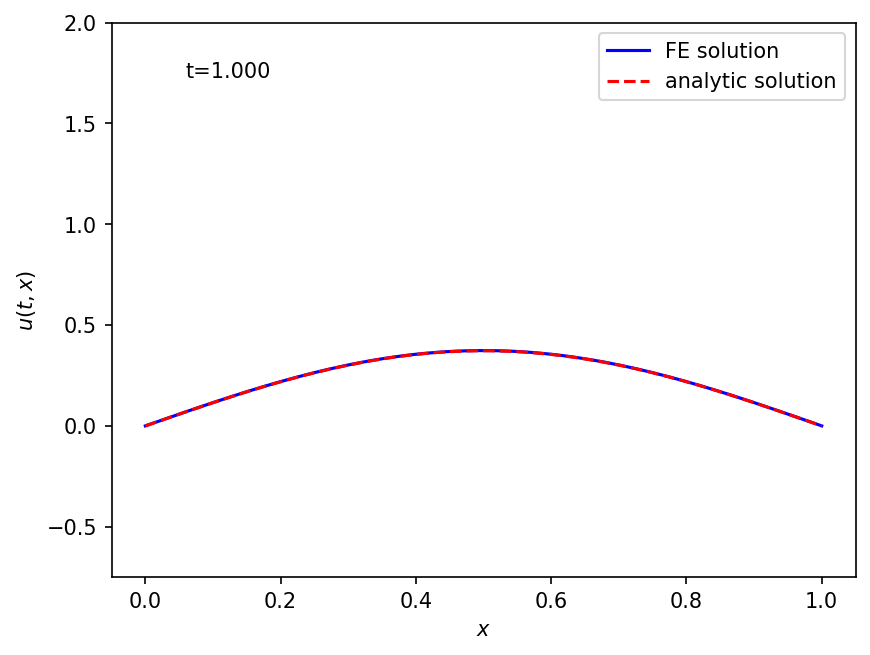

In [22]:
### ===============================================================================
### Create an animation using matplotlib
### also plot the analytic solution for comparison

x = np.linspace(0, 1, 129)
fig, ax = plt.subplots(dpi=150)

# plot FEM and analytic solution together
line_1, = ax.plot(x, lst_solutions[0].x.array, color='blue', label='FE solution')
line_2, = ax.plot(x, u_vec(0, x), '--', color='red', label='analytic solution')
ax.set_ylim(-0.75, 2.0)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u(t, x)$')
ax.legend(loc='upper right')
# add text which shows the current time step in each frame
time_count = ax.text(0.1, 0.9, 't=0.000', transform=ax.transAxes)

def update(frame):
    if frame <= 10:
        ### keep initial solution for first 10 frames
        y = lst_solutions[0].x.array
        z = u_vec(0, x)
        line_1.set_ydata(y)
        line_2.set_ydata(z)
        time_count.set_text('t=0.000')
    else:
        y = lst_solutions[frame - 10].x.array
        z = u_vec((frame - 10) * h, x)
        line_1.set_ydata(y)
        line_2.set_ydata(z)
        time_count.set_text('t={:.3f}'.format((frame - 10) * h))
    return line_1, line_2, time_count

ani = animation.FuncAnimation(fig, update, frames=len(lst_solutions) + 10, interval=100)
ani.save('1d_heat_equation.gif', writer='pillow')
plt.show()
